In [60]:
import random
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from pandarallel import pandarallel
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from dreams.utils.mols import MolPropertyCalculator
from dreams.utils.spectra import bin_peak_list
from dreams.utils.io import append_to_stem, read_pickle, write_pickle
from dreams.utils.plots import init_plotting, save_fig, get_nature_hex_colors
from dreams.definitions import NIST20

tqdm.pandas()
SEED = 3721
random.seed(SEED)
np.random.seed(SEED)
pandarallel.initialize(progress_bar=True, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
mol_property_calc = MolPropertyCalculator()

# Data

In [127]:
df_path = NIST20 / 'NIST20_MoNA_A_Murcko_split_MCE_test.pkl'
df = pd.read_pickle(df_path)
# df_path = NIST20 / 'NIST20_MoNA_A_Murcko_split_MCE_test.pkl'
# df.to_pickle(append_to_stem(df_path, 'xgboost'))
df

In [ ]:
def get_X_y(df_subset, label='BertzComplexity', all_labels=False):
    # Features
    X = np.stack(df_subset['PARSED PEAKS'].parallel_apply(lambda peaks: bin_peak_list(peaks, max_mz=1000, bin_step=0.1)))

    # Labels
    if all_labels:
        y = df_subset['ROMol'].parallel_apply(lambda mol: mol_property_calc.mol_to_props(mol, min_max_norm=True))
        y = y.apply(lambda dct: np.array(list(dct.values())))
        y = np.stack(y).T
    else:
        y = df_subset['ROMol'].parallel_apply(lambda mol: mol_property_calc.mol_to_props(mol, min_max_norm=True)[label]).values

    return X, y

In [ ]:
df_train = df[df['fold'] == 'train']
df_val = df[df['fold'] == 'val']
df_test = df[df['fold'] == 'test']

# df_train = df_train.drop_duplicates(subset=['SMILES'])

print(len(df_train), len(df_val), len(df_test))

439927 43040 28075


In [ ]:
X_train, y_train = get_X_y(df_train)

# Training

All training samples

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, tree_method='hist', verbosity=2, device='cuda')
model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# del X_train, y_train
X_test, y_test = get_X_y(df_val)

In [ ]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

/scratch/project/open-26-23/antonb/miniconda3/envs/msml/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:11:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.049265421517714396

In [ ]:
y_pred_denorm = mol_property_calc.denormalize_prop(y_pred, prop_name='BertzComplexity')
y_test_denorm = mol_property_calc.denormalize_prop(y_test, prop_name='BertzComplexity')
mean_absolute_error(y_test_denorm, y_pred_denorm)

184.54405217694534

In [ ]:
mean_absolute_error(y_test_denorm, np.full_like(y_pred_denorm, y_train.mean()))

770.0299938258278

Unique SMILES (similar to the original Gebhard2022 paper)

In [ ]:
df_train = df_train.drop_duplicates(subset=['SMILES'])
X_train, y_train = get_X_y(df_train)

model = xgb.XGBRegressor(n_estimators=1000, tree_method='hist', verbosity=2, device='cuda')
model.fit(X_train, y_train, verbose=True)

y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
y_pred_denorm = mol_property_calc.denormalize_prop(y_pred, prop_name='BertzComplexity')
y_test_denorm = mol_property_calc.denormalize_prop(y_test, prop_name='BertzComplexity')
print(mean_absolute_error(y_test_denorm, y_pred_denorm))

0.0556396889941916
208.42151160093417


In [ ]:
df_val = df[df['fold'] == 'val']
X_test, y_test = get_X_y(df_val)

# Explore hparams

In [ ]:
# X_train, y_train = get_X_y(df_train)
X_test, y_test = get_X_y(df_val)

In [ ]:
df_hparams = []
for tree_method in ["auto"]:  # "hist",
    for n_estimators in [100, 1000, 5000]:
        for max_depth in [3, 6]:
            for min_child_weight in [0.5, 1.0, 2.0]:
                print('Hparams', tree_method, n_estimators, max_depth, min_child_weight)
                
                model = xgb.XGBRegressor(
                    n_estimators=n_estimators, tree_method=tree_method,
                    max_depth=max_depth, min_child_weight=min_child_weight,
                    verbosity=2, device='cuda'
                )
                model.fit(X_train, y_train, verbose=True)
                
                y_pred = model.predict(X_test)
                print('Min-max normalized MAE', mean_absolute_error(y_test, y_pred))
        
                y_pred_denorm = mol_property_calc.denormalize_prop(y_pred, prop_name='BertzComplexity')
                y_test_denorm = mol_property_calc.denormalize_prop(y_test, prop_name='BertzComplexity')
                print('Denormalized MAE', mean_absolute_error(y_test_denorm, y_pred_denorm))

                df_hparams.append({
                    'tree_method': tree_method,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_child_weight': min_child_weight
                    'Denormalized MAE': mean_absolute_error(y_test_denorm, y_pred_denorm)
                })
df_hparams = pd.DataFrame(df_hparams)

Hparams auto 100 3 0.5


/scratch/project/open-26-23/antonb/miniconda3/envs/msml/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:13:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Min-max normalized MAE 0.05379018262167082
Denormalized MAE 201.49342056035582
Hparams auto 100 3 1.0
Min-max normalized MAE 0.05379018262167082
Denormalized MAE 201.49342056035582
Hparams auto 100 3 2.0
Min-max normalized MAE 0.05392606737548175
Denormalized MAE 202.00243320596724
Hparams auto 100 6 0.5
Min-max normalized MAE 0.05150098402905041
Denormalized MAE 192.918278465481
Hparams auto 100 6 1.0
Min-max normalized MAE 0.05150098402905041
Denormalized MAE 192.918278465481
Hparams auto 100 6 2.0
Min-max normalized MAE 0.05151292819710851
Denormalized MAE 192.96301993000046
Hparams auto 1000 3 0.5
Min-max normalized MAE 0.05000543030098822
Denormalized MAE 187.31606204828503
Hparams auto 1000 3 1.0
Min-max normalized MAE 0.05000543030098822
Denormalized MAE 187.31606204828503
Hparams auto 1000 3 2.0
Min-max normalized MAE 0.05004999988898912
Denormalized MAE 187.4830156928436
Hparams auto 1000 6 0.5
Min-max normalized MAE 0.049265421517714396
Denormalized MAE 184.54405217694534
Hpa

# Multi-output for all properties in a simple for loop

In [ ]:
X_train, y_train = get_X_y(df_train, all_labels=True)
X_test, y_test = get_X_y(df_val, all_labels=True)

In [ ]:
df_pred = []
for i, label in enumerate(mol_property_calc.prop_names):
    print(label)
    # X_train, y_train = get_X_y(df_train, label=label)
    # X_test, y_test = get_X_y(df_val, label=label)
    X_train_task = X_train
    y_train_task = y_train[i, :]
    X_test_task = X_test
    y_test_task = y_test[i, :]

    model = xgb.XGBRegressor(n_estimators=1000, tree_method='hist', verbosity=2, device='cuda')
    model.fit(X_train_task, y_train_task, verbose=True)

    y_pred_task = model.predict(X_test_task)
    print('Min-max normalized MAE', mean_absolute_error(y_test_task, y_pred_task))

    y_pred_task_denorm = mol_property_calc.denormalize_prop(y_pred_task, prop_name=label)
    y_test_task_denorm = mol_property_calc.denormalize_prop(y_test_task, prop_name=label)
    print('Denormalized MAE', mean_absolute_error(y_test_task_denorm, y_pred_task_denorm))

    df_pred.append({
        'label': label,
        'y_test': y_test_task_denorm,
        'y_pred': y_pred_task_denorm,
        'mae': mean_absolute_error(y_test_task_denorm, y_pred_task_denorm)
    })
df_pred = pd.DataFrame(df_pred)
df_pred

AtomicLogP
Min-max normalized MAE 0.033455613667360586
Denormalized MAE 1.3350128521344644
NumHAcceptors
Min-max normalized MAE 0.048461810695090146
Denormalized MAE 1.7446251845998226
NumHDonors
Min-max normalized MAE 0.05866244543226068
Denormalized MAE 1.1732489089561162
PolarSurfaceArea
Min-max normalized MAE 0.0506599429409692
Denormalized MAE 29.63758696843764
NumRotatableBonds
Min-max normalized MAE 0.03380073369464886
Denormalized MAE 2.298449889854372
NumAromaticRings
Min-max normalized MAE 0.0816943810916883
Denormalized MAE 0.6535550487335064
NumAliphaticRings
Min-max normalized MAE 0.037973294578821225
Denormalized MAE 0.8354124805162969
FractionCSP3
Min-max normalized MAE 0.1294723732241941
Denormalized MAE 0.1294723732241941
QED
Min-max normalized MAE 0.1516012380559737
Denormalized MAE 0.14235172379083666
SyntheticAccessibility
Min-max normalized MAE 0.09739599319491198
Denormalized MAE 0.680706873124827
BertzComplexity
Min-max normalized MAE 0.049265421517714396
Denorma

,label,y_test,y_pred,mae
0,AtomicLogP,"[6.2235000000000085, 0.10010000000000474, 4.08...","[6.7385178, 2.465251, 2.4496841, 2.3276377, 2....",1.335013
1,NumHAcceptors,"[3.0, 17.0, 1.0, 2.0, 5.0, 2.0, 3.0, 14.0, 2.0...","[3.982305, 4.7399654, 2.7345405, 0.91799223, 5...",1.744625
2,NumHDonors,"[2.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 10.0, 1.0,...","[1.6376777, 1.4385169, 0.9599405, 0.8010384, 1...",1.173249
3,PolarSurfaceArea,"[49.68999999999999, 237.44999999999996, 20.310...","[78.43336, 74.10846, 46.812992, 28.403942, 89....",29.637587
4,NumRotatableBonds,"[7.0, 5.0, 3.0, 2.0, 1.0, 1.0, 3.0, 6.0, 1.0, ...","[8.721856, 4.2885084, 3.3022237, 1.4894134, 5....",2.298450
5,NumAromaticRings,"[1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...","[0.24332678, 1.5257038, 1.6320176, 1.6830934, ...",0.653555
6,NumAliphaticRings,"[2.0, 4.0, 1.0, 1.0, 3.0, 1.0, 0.0, 3.0, 4.0, ...","[1.3406944, 0.97851187, 0.21028906, 0.01467166...",0.835412
7,FractionCSP3,"[0.68, 0.6470588235294118, 0.35, 0.35714285714...","[0.7366483, 0.37394094, 0.2339149, 0.26664606,...",0.129472
8,QED,"[0.43164197376289165, 0.30304382275227487, 0.8...","[0.3501105, 0.6452686, 0.70918614, 0.77581835,...",0.142352
9,SyntheticAccessibility,"[3.774487323924852, 7.511818198878913, 1.62016...","[2.9146833, 2.9782104, 1.9234526, 1.8340963, 4...",0.680707


In [ ]:
df_pred.to_pickle('tmp_preds.pkl')

# Multi-output for all properties (some bug)

In [ ]:
X_train, y_train = get_X_y(df_train, all_labels=True)
X_test, y_test = get_X_y(df_val, all_labels=True)

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, tree_method='hist', verbosity=2, device='cuda')
model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

/scratch/project/open-26-23/antonb/miniconda3/envs/msml/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [19:26:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
mean_absolute_error(y_test, y_pred, multioutput='raw_values')

array([0.17658807, 0.11155517, 0.15480777, 0.11573937, 0.16525837,
       0.11503644, 0.16048905, 0.24284307, 0.4091283 , 0.15641142,
       0.05707911])

In [ ]:
def unnormalize_y(y):
    y_unnorm = []
    for row in y:
        row_dct = dict(zip(mol_property_calc.prop_names, row))
        y_unnorm.append(list(mol_property_calc.denormalize_props(row_dct).values()))
    return np.stack(y_unnorm)

In [ ]:
y_test_unnorm = unnormalize_y(y_test)
y_pred_unnorm = unnormalize_y(y_pred)

In [ ]:
mean_absolute_error(y_test_unnorm, y_pred_unnorm, multioutput='raw_values')

array([  7.04657025,   4.015986  ,   3.09615532,  67.71100351,
        11.23756896,   0.9202915 ,   3.53075919,   0.24284307,
         0.38416651,   1.0931695 , 213.8134753 ])

# Visualize

## Load all data

In [3]:
colors = get_nature_hex_colors()
col_names = mol_property_calc.prop_names

In [15]:
# df_dreams = read_pickle('/scratch/project/open-26-5/dreams/dreams/data/merged/datasets/NIST20_MoNA_A_Murcko_split_MCE_test_dreams_preds_val.pkl')
df_dreams = read_pickle('/scratch/project/open-26-5/dreams/dreams/data/merged/datasets/NIST20_MoNA_A_Murcko_split_MCE_test_dreams_preds_step4000_val.pkl')
df_ms2prop = read_pickle('/scratch/project/open-26-5/dreams/dreams/data/merged/datasets/NIST20_MoNA_A_Murcko_split_MCE_test_ms2prop_preds_val.pkl')
print(df_dreams.columns)
df_pred = pd.read_pickle('tmp_preds.pkl')

Index(['ID', 'PARSED PEAKS', 'SMILES', 'PRECURSOR M/Z', 'FORMULA', 'CHARGE',
       'ROMol', 'COLLISION ENERGY', 'PRECURSOR TYPE', 'MSnSpectrum', 'fold',
       'AtomicLogP', 'NumHAcceptors', 'NumHDonors', 'PolarSurfaceArea',
       'NumRotatableBonds', 'NumAromaticRings', 'NumAliphaticRings',
       'FractionCSP3', 'QED', 'SyntheticAccessibility', 'BertzComplexity'],
      dtype='object')


In [32]:
# res_kind = 'ms2prop'
# res_kind = 'gebhard'
res_kind = 'raw'

# True
df_true_unif = {
    label: df_pred[df_pred['label'] == label].iloc[0]['y_test']
    for i, label in enumerate(col_names)
}
df_true_unif = pd.DataFrame(df_true_unif)

# XGBoost
df_xgb_unif = {
    label: df_pred[df_pred['label'] == label].iloc[0]['y_pred']
    for i, label in enumerate(col_names)
}
df_xgb_unif = pd.DataFrame(df_xgb_unif)
if res_kind == 'ms2prop':
    df_xgb_unif = (df_xgb_unif - df_true_unif).abs()
elif res_kind == 'gebhard':
    df_xgb_unif = (df_true_unif - df_xgb_unif) / df_true_unif
elif res_kind == 'raw':
    df_xgb_unif = df_xgb_unif.join(df_true_unif, rsuffix='_true')
df_xgb_unif['Method'] = 'XGBoost'

# DreaMS
df_dreams_unif = df_dreams[col_names].copy()
if res_kind == 'ms2prop':
    df_dreams_unif = (df_dreams_unif - df_true_unif).abs()
elif res_kind == 'gebhard':
    df_dreams_unif = (df_true_unif - df_dreams_unif) / df_true_unif
elif res_kind == 'raw':
    df_dreams_unif = df_dreams_unif.join(df_true_unif, rsuffix='_true')
df_dreams_unif['Method'] = 'DreaMS'

# ms2prop
df_ms2prop_unif = df_ms2prop[col_names].copy()
if res_kind == 'ms2prop':
    df_ms2prop_unif = (df_ms2prop_unif - df_true_unif).abs()
elif res_kind == 'gebhard':
    df_ms2prop_unif = (df_true_unif - df_ms2prop_unif) / df_true_unif
elif res_kind == 'raw':
    df_ms2prop_unif = df_ms2prop_unif.join(df_true_unif, rsuffix='_true')
df_ms2prop_unif['Method'] = 'ms2prop'

# Concat all
df_res = pd.concat([df_dreams_unif, df_ms2prop_unif, df_xgb_unif])
df_res

,AtomicLogP,NumHAcceptors,NumHDonors,PolarSurfaceArea,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,QED,SyntheticAccessibility,...,NumHDonors_true,PolarSurfaceArea_true,NumRotatableBonds_true,NumAromaticRings_true,NumAliphaticRings_true,FractionCSP3_true,QED_true,SyntheticAccessibility_true,BertzComplexity_true,Method
0,6.731758,3.540229,1.652131,61.961338,14.943428,0.446101,0.364501,0.686691,0.271515,3.151714,...,2.0,49.69,7.0,1.0,2.0,0.680000,0.431642,3.774487,729.553658,DreaMS
1,3.477448,11.550164,2.878635,177.829178,9.544861,1.850924,2.670073,0.463941,0.186014,5.493705,...,2.0,237.45,5.0,1.0,4.0,0.647059,0.303044,7.511818,1674.384898,DreaMS
2,2.807122,2.413619,1.182161,45.909302,2.588801,1.356848,0.106988,0.168039,0.684260,1.918467,...,0.0,20.31,3.0,2.0,1.0,0.350000,0.834397,1.620167,609.915321,DreaMS
3,3.183191,2.058980,0.922642,31.854052,1.382321,1.631702,-0.056082,0.181465,0.768693,1.990211,...,2.0,40.71,2.0,2.0,1.0,0.357143,0.874362,2.411749,573.820096,DreaMS
4,3.196583,6.118458,1.842827,88.350418,6.594951,0.229317,1.563666,0.533726,0.389070,4.910796,...,1.0,72.83,1.0,0.0,3.0,0.647059,0.453802,4.667914,573.598372,DreaMS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43035,1.725327,4.470552,2.427294,88.082176,5.865006,0.751437,1.055321,0.498514,0.507607,3.504961,...,7.0,203.44,7.0,1.0,2.0,0.565217,0.248723,4.427873,958.199215,XGBoost
43036,2.077209,4.006895,1.024933,57.194668,2.877165,1.846790,0.608632,0.323655,0.658220,2.389581,...,2.0,75.62,6.0,3.0,0.0,0.125000,0.726737,2.046551,622.346398,XGBoost
43037,1.808727,2.812427,1.066664,58.884235,2.798161,1.726760,0.332632,0.263034,0.646972,2.101552,...,1.0,68.92,3.0,3.0,0.0,0.117647,0.805655,2.015663,895.592845,XGBoost
43038,2.734224,4.192678,1.846863,74.511681,4.591607,1.821265,0.895094,0.393370,0.580425,3.158593,...,0.0,65.07,6.0,3.0,0.0,0.304348,0.359137,2.495059,1089.751215,XGBoost


## Gebhard 2022 benchmark

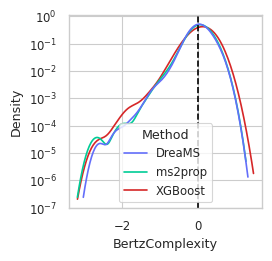

In [17]:
init_plotting(figsize=(2.5, 2.5))
sns.kdeplot(df_res, x='BertzComplexity', hue='Method', bw_adjust=5)
plt.axvline(0, color='black', ls='--')
plt.yscale('log')

<Axes: xlabel='BertzComplexity', ylabel='Count'>

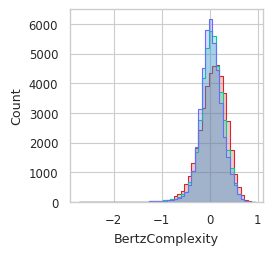

In [30]:
init_plotting(figsize=(2.5, 2.5))
sns.histplot(df_res, x='BertzComplexity', hue='Method', element="step", legend=False, bins=50)

<Axes: ylabel='BertzComplexity'>

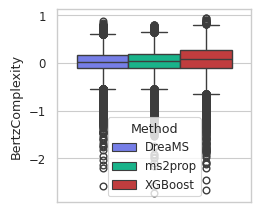

In [19]:
init_plotting(figsize=(2.5, 2.5))
sns.boxplot(df_res, y='BertzComplexity', hue='Method')

<Axes: >

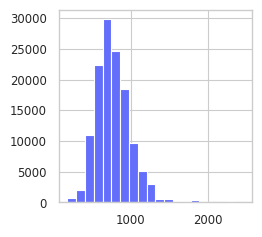

In [35]:
df_res['BertzComplexity_true'].hist(bins=20)

In [36]:
df_res

,AtomicLogP,NumHAcceptors,NumHDonors,PolarSurfaceArea,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,QED,SyntheticAccessibility,...,NumHDonors_true,PolarSurfaceArea_true,NumRotatableBonds_true,NumAromaticRings_true,NumAliphaticRings_true,FractionCSP3_true,QED_true,SyntheticAccessibility_true,BertzComplexity_true,Method
0,6.731758,3.540229,1.652131,61.961338,14.943428,0.446101,0.364501,0.686691,0.271515,3.151714,...,2.0,49.69,7.0,1.0,2.0,0.680000,0.431642,3.774487,729.553658,DreaMS
1,3.477448,11.550164,2.878635,177.829178,9.544861,1.850924,2.670073,0.463941,0.186014,5.493705,...,2.0,237.45,5.0,1.0,4.0,0.647059,0.303044,7.511818,1674.384898,DreaMS
2,2.807122,2.413619,1.182161,45.909302,2.588801,1.356848,0.106988,0.168039,0.684260,1.918467,...,0.0,20.31,3.0,2.0,1.0,0.350000,0.834397,1.620167,609.915321,DreaMS
3,3.183191,2.058980,0.922642,31.854052,1.382321,1.631702,-0.056082,0.181465,0.768693,1.990211,...,2.0,40.71,2.0,2.0,1.0,0.357143,0.874362,2.411749,573.820096,DreaMS
4,3.196583,6.118458,1.842827,88.350418,6.594951,0.229317,1.563666,0.533726,0.389070,4.910796,...,1.0,72.83,1.0,0.0,3.0,0.647059,0.453802,4.667914,573.598372,DreaMS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43035,1.725327,4.470552,2.427294,88.082176,5.865006,0.751437,1.055321,0.498514,0.507607,3.504961,...,7.0,203.44,7.0,1.0,2.0,0.565217,0.248723,4.427873,958.199215,XGBoost
43036,2.077209,4.006895,1.024933,57.194668,2.877165,1.846790,0.608632,0.323655,0.658220,2.389581,...,2.0,75.62,6.0,3.0,0.0,0.125000,0.726737,2.046551,622.346398,XGBoost
43037,1.808727,2.812427,1.066664,58.884235,2.798161,1.726760,0.332632,0.263034,0.646972,2.101552,...,1.0,68.92,3.0,3.0,0.0,0.117647,0.805655,2.015663,895.592845,XGBoost
43038,2.734224,4.192678,1.846863,74.511681,4.591607,1.821265,0.895094,0.393370,0.580425,3.158593,...,0.0,65.07,6.0,3.0,0.0,0.304348,0.359137,2.495059,1089.751215,XGBoost


In [124]:
# thrs = [500, 750, 1000, 1250, 1500]
thrs = range(0, 1500, 250)
n_bootstrap = 10

df_thr = []
for method in df_res['Method'].unique():
    for thr in thrs:
        for i in tqdm(range(n_bootstrap), desc=f'{method}, {thr}'):
            df_tmp = df_res[(df_res['Method'] == method) & (df_res['BertzComplexity_true'] > thr)]
            df_tmp = df_tmp.sample(frac=1.0, replace=True)
            mae = ((df_tmp['BertzComplexity_true'] - df_tmp['BertzComplexity']) / df_tmp['BertzComplexity_true']).abs().mean()
            # mae = ((df_tmp['BertzComplexity_true'] - df_tmp['BertzComplexity'])).abs().mean()
            df_thr.append([method, thr, mae])
df_thr = pd.DataFrame(df_thr)
df_thr.columns = ['Method', 'Threshold', 'MAE']
df_thr

XGBoost, 1250: 100%|██████████| 10/10 [00:00<00:00, 125.18it/s]


,Method,Threshold,MAE
0,DreaMS,0,0.179993
1,DreaMS,0,0.180512
2,DreaMS,0,0.181811
3,DreaMS,0,0.179865
4,DreaMS,0,0.181803
...,...,...,...
175,XGBoost,1250,0.389640
176,XGBoost,1250,0.370828
177,XGBoost,1250,0.378193
178,XGBoost,1250,0.392256


<Axes: xlabel='BertzComplexity_true', ylabel='Probability'>

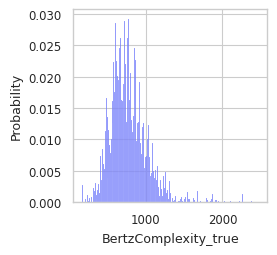

In [125]:
sns.histplot(data=df_res, x='BertzComplexity_true', stat='probability')

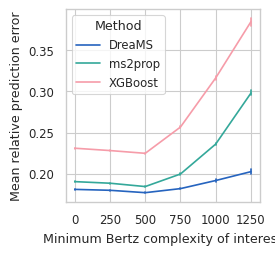

In [137]:
fig, ax = plt.subplots()
sns.lineplot(data=df_thr, x='Threshold', y='MAE', hue='Method', err_style="bars", errorbar=('ci', 99), ax=ax, palette=[colors[0], colors[1], colors[2]],)
plt.xticks(thrs)
plt.xlabel('Minimum Bertz complexity of interest')
plt.ylabel('Mean relative prediction error')
save_fig(f'bertz_complexity_thrs.svg')
plt.show()

## ms2prop benchmark

Rerun res with `absolute=True` first

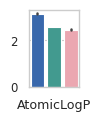

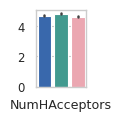

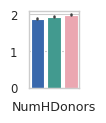

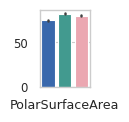

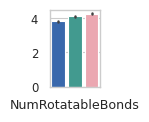

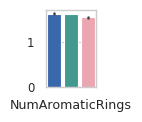

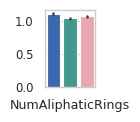

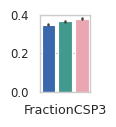

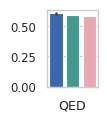

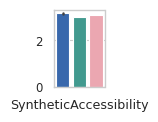

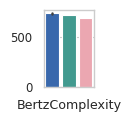

In [139]:
init_plotting(figsize=(0.65, 1))
# init_plotting(figsize=(3*0.65, 2*1))
for col_name in col_names:
    sns.barplot(
        df_res,
        x='Method',
        y=col_name,
        palette=[colors[0], colors[1], colors[2]],
        hue='Method',
    )
    plt.title(col_name, y=-0.4)
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('')
    # plt.legend([],[], frameon=False)
    save_fig(f'ms2prop_{col_name.replace(" ", "_")}.svg')
    plt.show()
    # break

In [ ]:
df_res

,AtomicLogP,NumHAcceptors,NumHDonors,PolarSurfaceArea,NumRotatableBonds,NumAromaticRings,NumAliphaticRings,FractionCSP3,QED,SyntheticAccessibility,BertzComplexity,Method
0,0.512795,0.098117,0.655697,15.289149,7.771688,0.462563,1.272756,0.029800,0.137556,0.739770,202.192574,DreaMS
1,1.976512,4.098907,1.318449,36.482974,6.223182,0.763852,0.687734,0.169986,0.223226,1.998454,86.683726,DreaMS
2,2.269388,1.004315,1.115834,24.250436,0.470176,0.588252,0.769656,0.155531,0.129865,0.137407,221.852394,DreaMS
3,0.465352,0.138355,1.048145,16.221864,0.148149,0.552515,0.722617,0.116698,0.101407,0.501351,173.767300,DreaMS
4,0.262306,0.849551,0.540083,18.323137,4.660686,0.152493,0.968974,0.097799,0.029630,0.172898,37.213457,DreaMS
...,...,...,...,...,...,...,...,...,...,...,...,...
43035,1.702327,6.529448,4.572706,115.357824,1.134994,0.248563,0.944679,0.066704,0.258885,0.922912,341.940426,XGBoost
43036,0.413591,1.993105,0.975067,18.425332,3.122835,1.153210,0.608632,0.198655,0.068517,0.343031,32.577735,XGBoost
43037,0.322993,2.187573,0.066664,10.035765,0.201839,1.273240,0.332632,0.145387,0.158684,0.085889,402.611949,XGBoost
43038,1.222076,0.807322,1.846863,9.441681,1.408393,1.178735,0.895094,0.089022,0.221288,0.663534,324.888300,XGBoost
